In [1]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline
import os 

In [2]:
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-296', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']

rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG']
roi_names=['L_'+roi for roi in rois]+['R_'+roi for roi in rois] 

In [21]:
def get_result_dataset_normalized(dataset,layer_num):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        rep_name='layer_'+str(layer_num)
        result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"_activations/"
        fullwidth_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-fullwidth-holdout_-1/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            results_sub_parcels_fullwidth=np.load(fullwidth_dir+sub+"_parcelwise_results.npy")
            results_sub_parcels=results_sub_parcels/results_sub_parcels_fullwidth
            results_sub_parcels[results_sub_parcels<0]=0
            #print(results_sub_parcels.mean())
            results_sub=np.zeros((20,))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    return np.concatenate(results,axis=0)

def get_result_dataset_heldout(dataset,layer_num):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        rep_name='layer_'+str(layer_num)
        result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-fullwidth-holdout_"+str(layer_num)+"/"
        fullwidth_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-fullwidth-holdout_-1/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            results_sub_parcels_fullwidth=np.load(fullwidth_dir+sub+"_parcelwise_results.npy")
            results_sub_parcels=(results_sub_parcels_fullwidth-results_sub_parcels)/results_sub_parcels_fullwidth
            #print(results_sub_parcels_fullwidth.mean())
            #print(results_sub_parcels.mean())
            results_sub=np.zeros((20,))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    return np.concatenate(results,axis=0)

def get_weight_dataset(dataset,layer_num):
    print(layer_num)
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        rep_name='layer_'+str(layer_num)
        fullwidth_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-fullwidth-holdout_-1/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            weights_fullwidth=np.load(fullwidth_dir+sub+"_encoding_weights.npy")[:,0,:]
            n_delay=int(weights_fullwidth.shape[1]/4)
            weights_delays=np.mean([weights_fullwidth[:,d*n_delay:(d+1)*n_delay] for d in range(4)],axis=0)
            n_layer=768
            weights_layers=np.mean([weights_delays[:,d*n_layer:(d+1)*n_layer] for d in range(13)],axis=2)
            results_sub_parcels=weights_layers[layer_num]/np.sum(weights_layers,axis=0) 
            #print(results_sub_parcels.mean())
            results_sub=np.zeros((20,13))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    return np.concatenate(results,axis=0)

def get_result_mixing(dataset):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-mixing/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            results_sub=np.zeros((20,13))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean(axis=0)
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    return np.concatenate(results,axis=0)

def get_result_mixing_z(dataset):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-mixing_z/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            results_sub=np.zeros((20,12))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean(axis=0)
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    return np.concatenate(results,axis=0)

def get_result_dataset(dataset,rep_name,noyank=0):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'layer' not in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            if noyank==2:
                results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results_yankembeddings.npy")
            elif noyank==1:
                results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results_noyank.npy")
            else:
                results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            results_sub=np.zeros((20,))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    return np.concatenate(results,axis=0)



(13, 20)


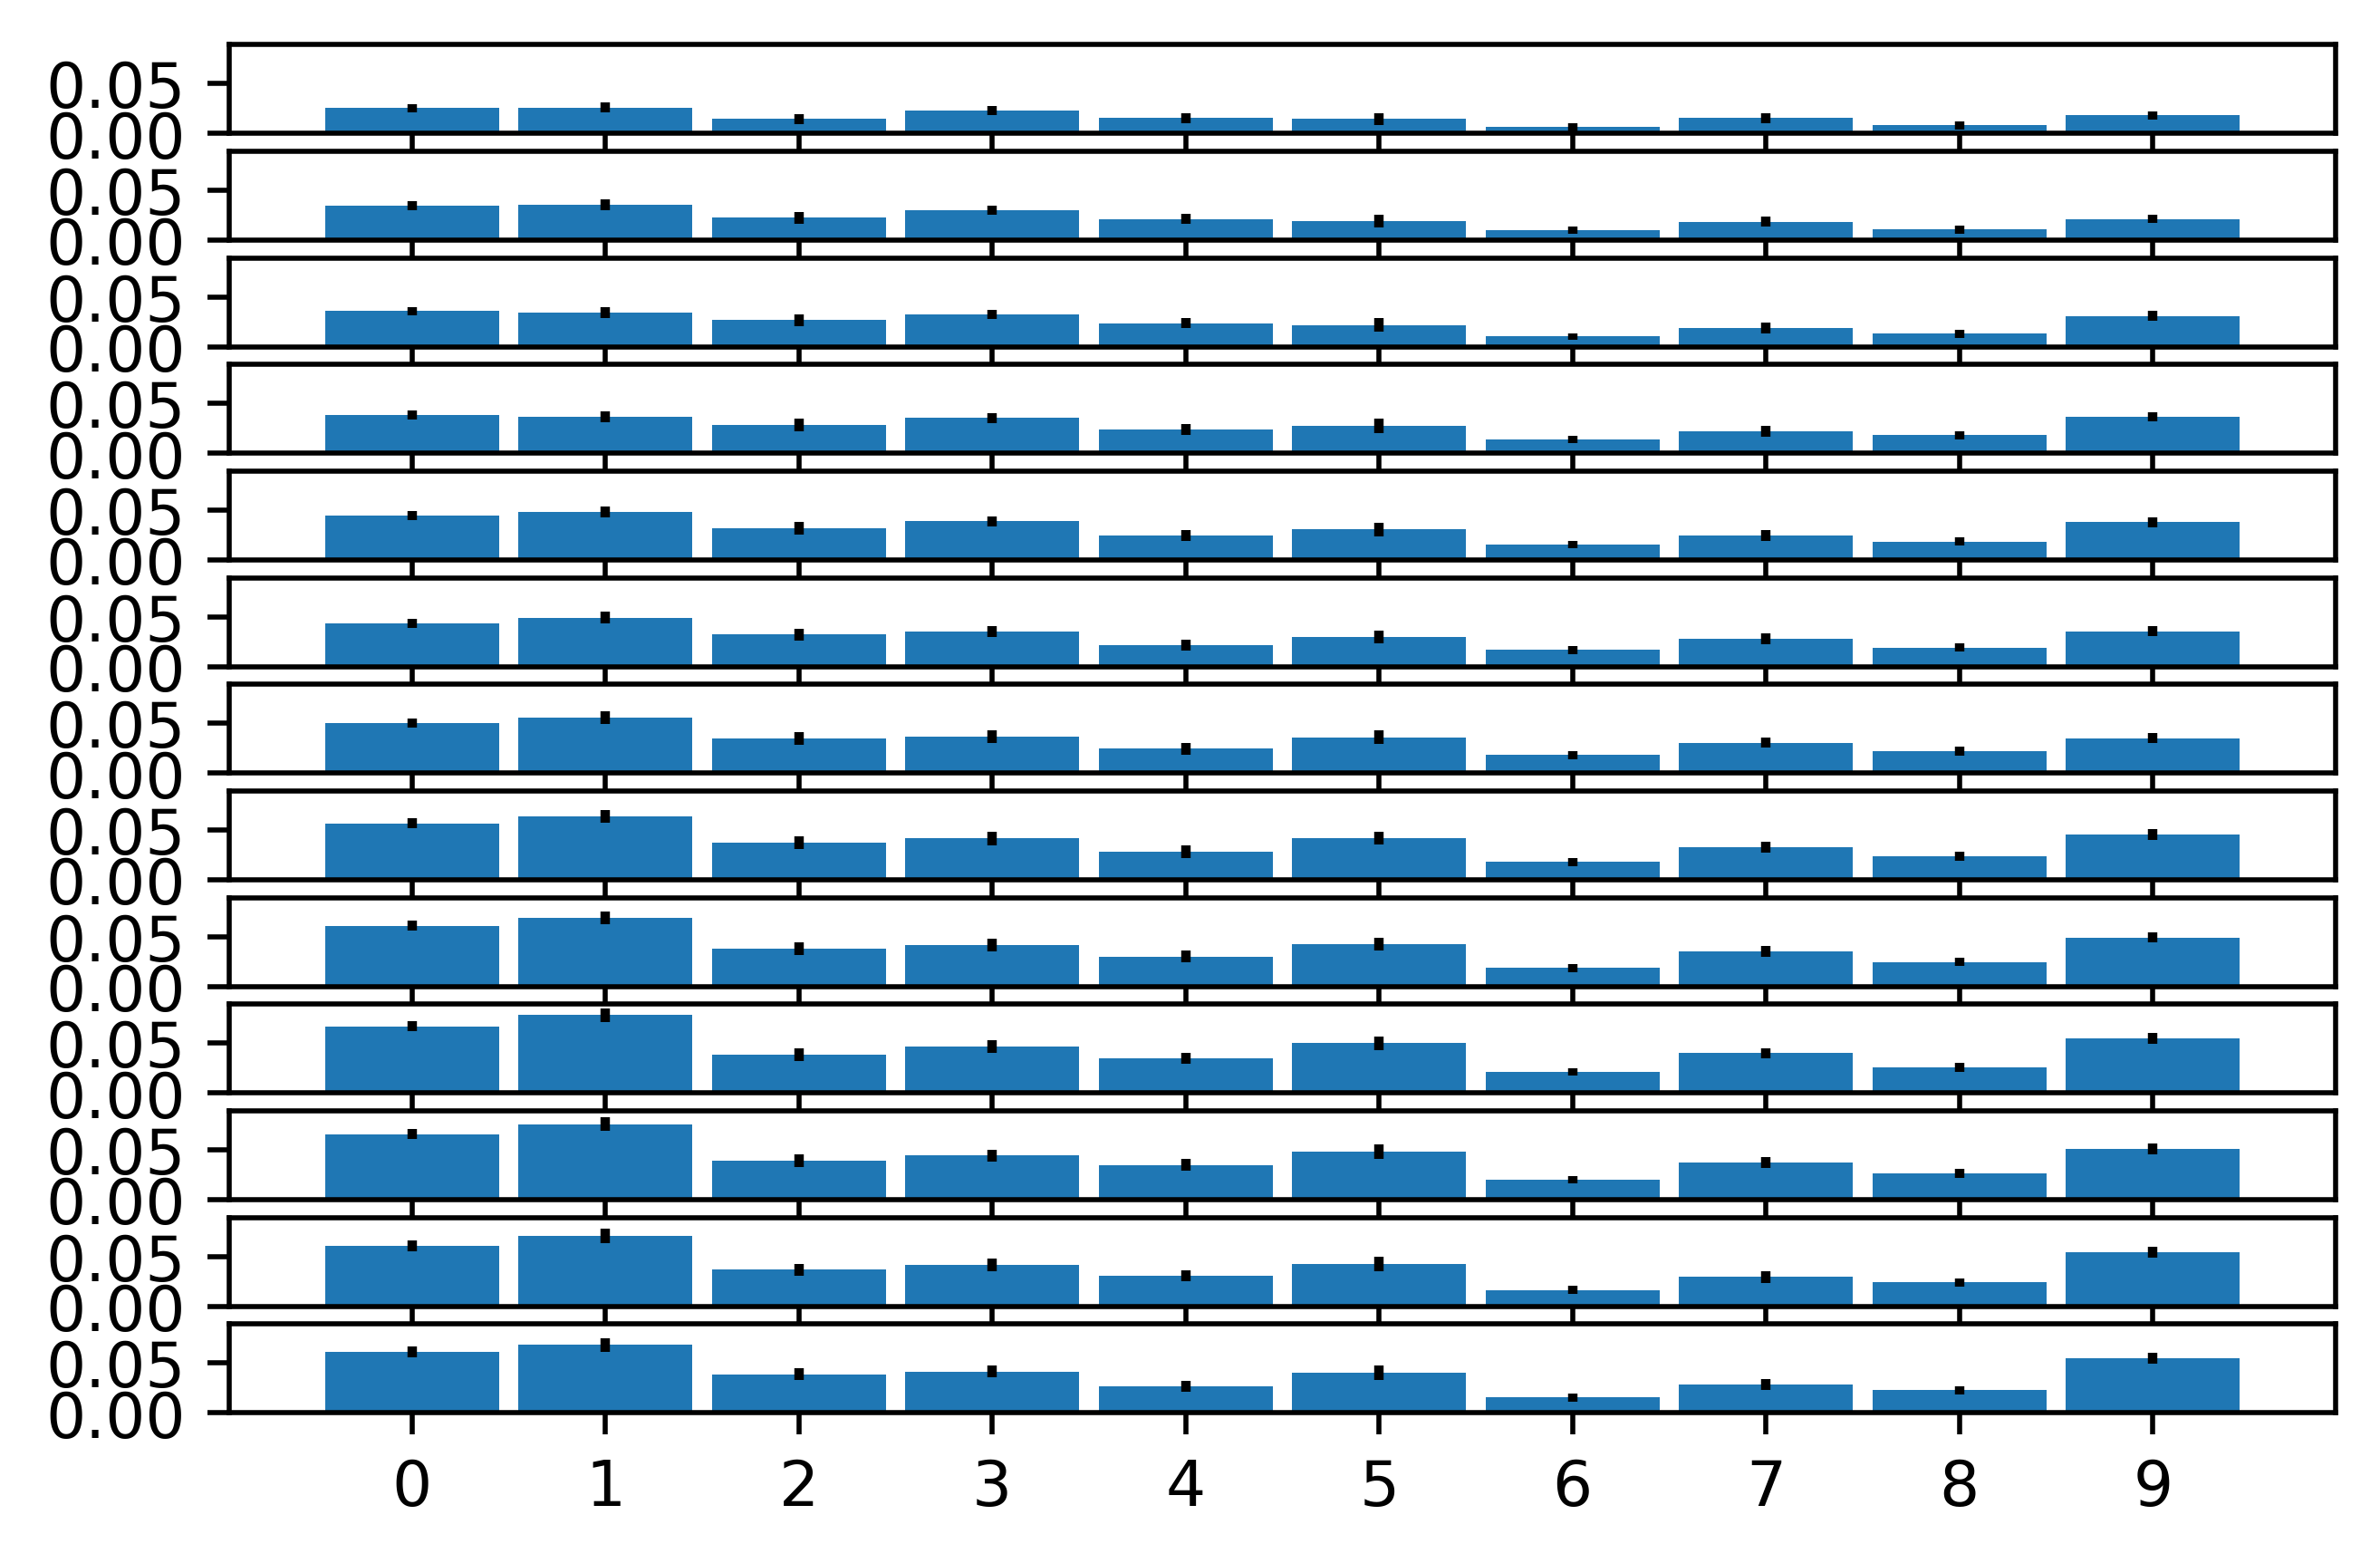

In [33]:
z_reps=['layer_'+str(i)+"_z_representations" for i in range(12)]
layer_reps=['layer_'+str(i)+"_activations" for i in range(13)]
layer_reps_mat=np.asarray([get_result_dataset(['black','slumlordreach'],layer_reps[i]) for i in range(13)]).mean(axis=1)
errors=np.asarray([get_result_dataset(['black','slumlordreach'],layer_reps[i]) for i in range(13)]).std(axis=1)/np.sqrt(63)
print(layer_reps_mat.shape)
layer_reps_mat=np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]).mean(axis=0)
errors=np.asarray([errors[:,:10],errors[:,10:]]).mean(axis=0)
fig,axarr=plt.subplots(nrows=13,sharex=True,sharey=True,dpi=500)
for i in range(13):
    axarr[i].bar(list(range(10)),layer_reps_mat[i],width=0.9,yerr=errors[i])
    axarr[i].set_xticks(list(range(10)))
    #axarr[i].set_title(rois[i])
#fig.tight_layout()

(12, 20)


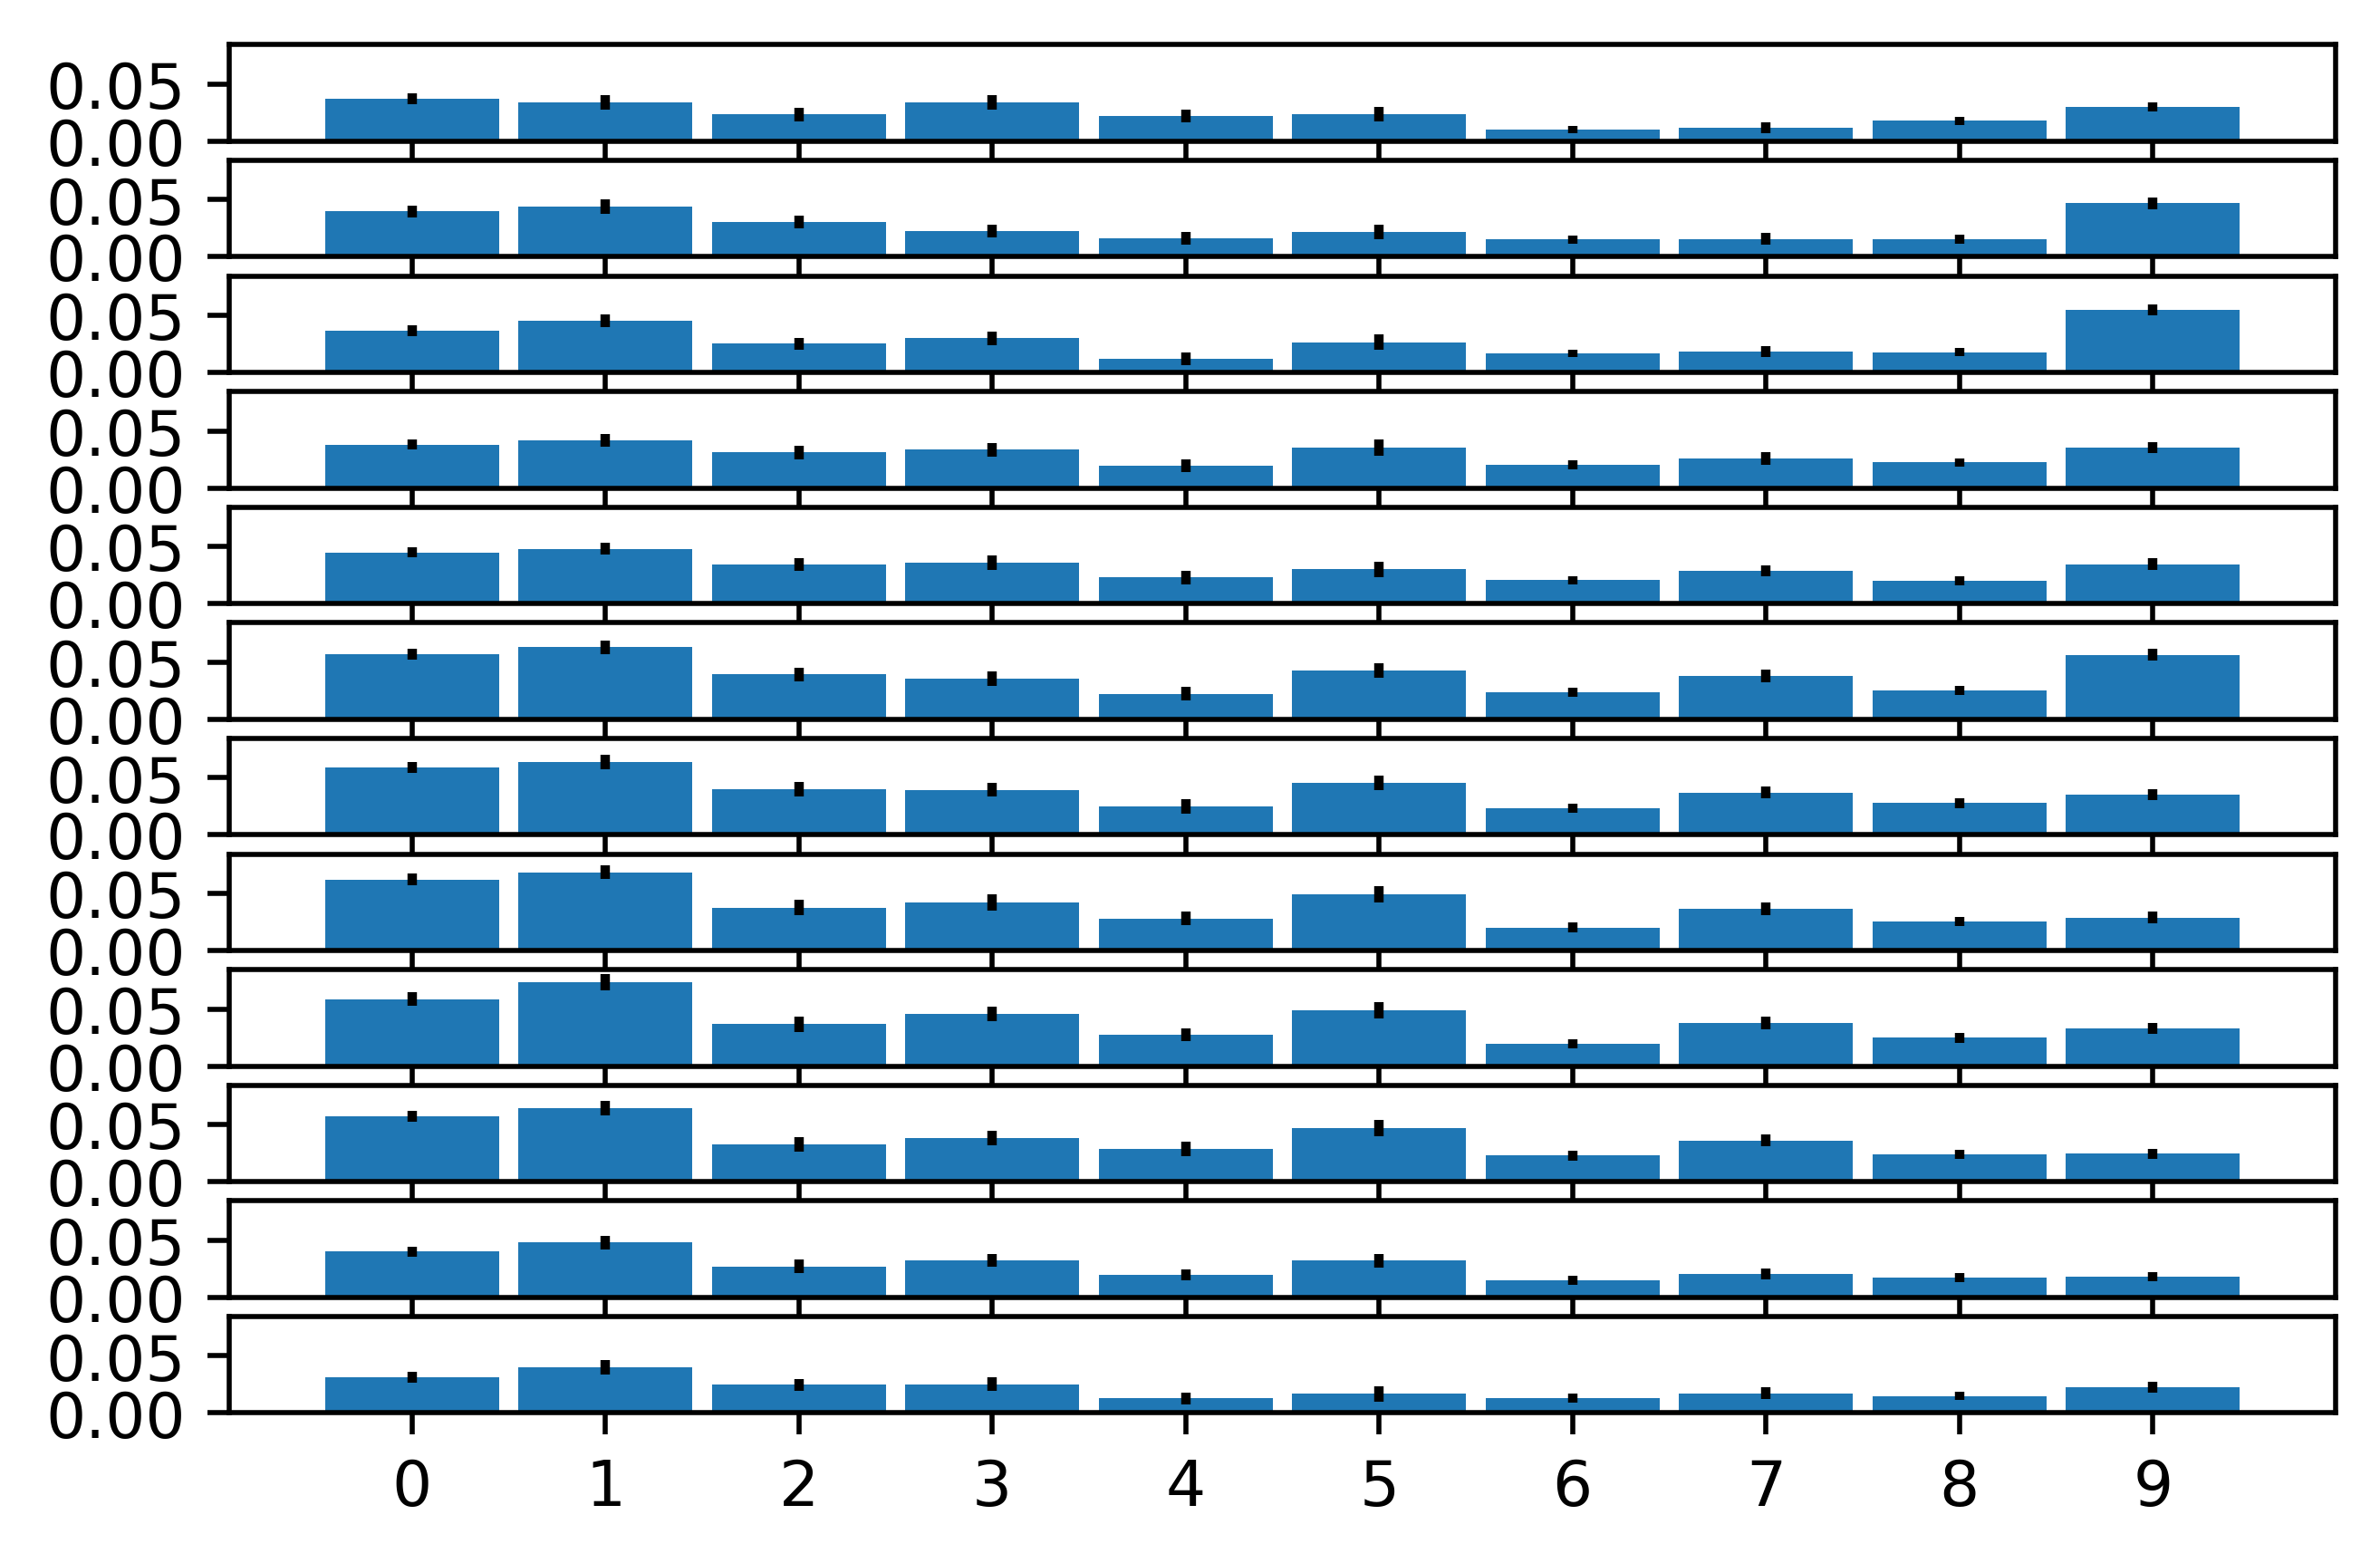

In [35]:
z_reps=['layer_'+str(i)+"_z_representations" for i in range(12)]
layer_reps=['layer_'+str(i)+"_activations" for i in range(13)]
layer_reps_mat=np.asarray([get_result_dataset(['black','slumlordreach'],z_reps[i]) for i in range(12)]).mean(axis=1)
errors=np.asarray([get_result_dataset(['black','slumlordreach'],z_reps[i]) for i in range(12)]).std(axis=1)/np.sqrt(63)
print(layer_reps_mat.shape)
layer_reps_mat=np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]).mean(axis=0)
errors=np.asarray([errors[:,:10],errors[:,10:]]).mean(axis=0)
fig,axarr=plt.subplots(nrows=12,sharex=True,sharey=True,dpi=500)
for i in range(12):
    axarr[i].bar(list(range(10)),layer_reps_mat[i],width=0.9,yerr=errors[i])
    axarr[i].set_xticks(list(range(10)))
    #axarr[i].set_title(rois[i])
#fig.tight_layout()

(13, 20)
(13, 10)


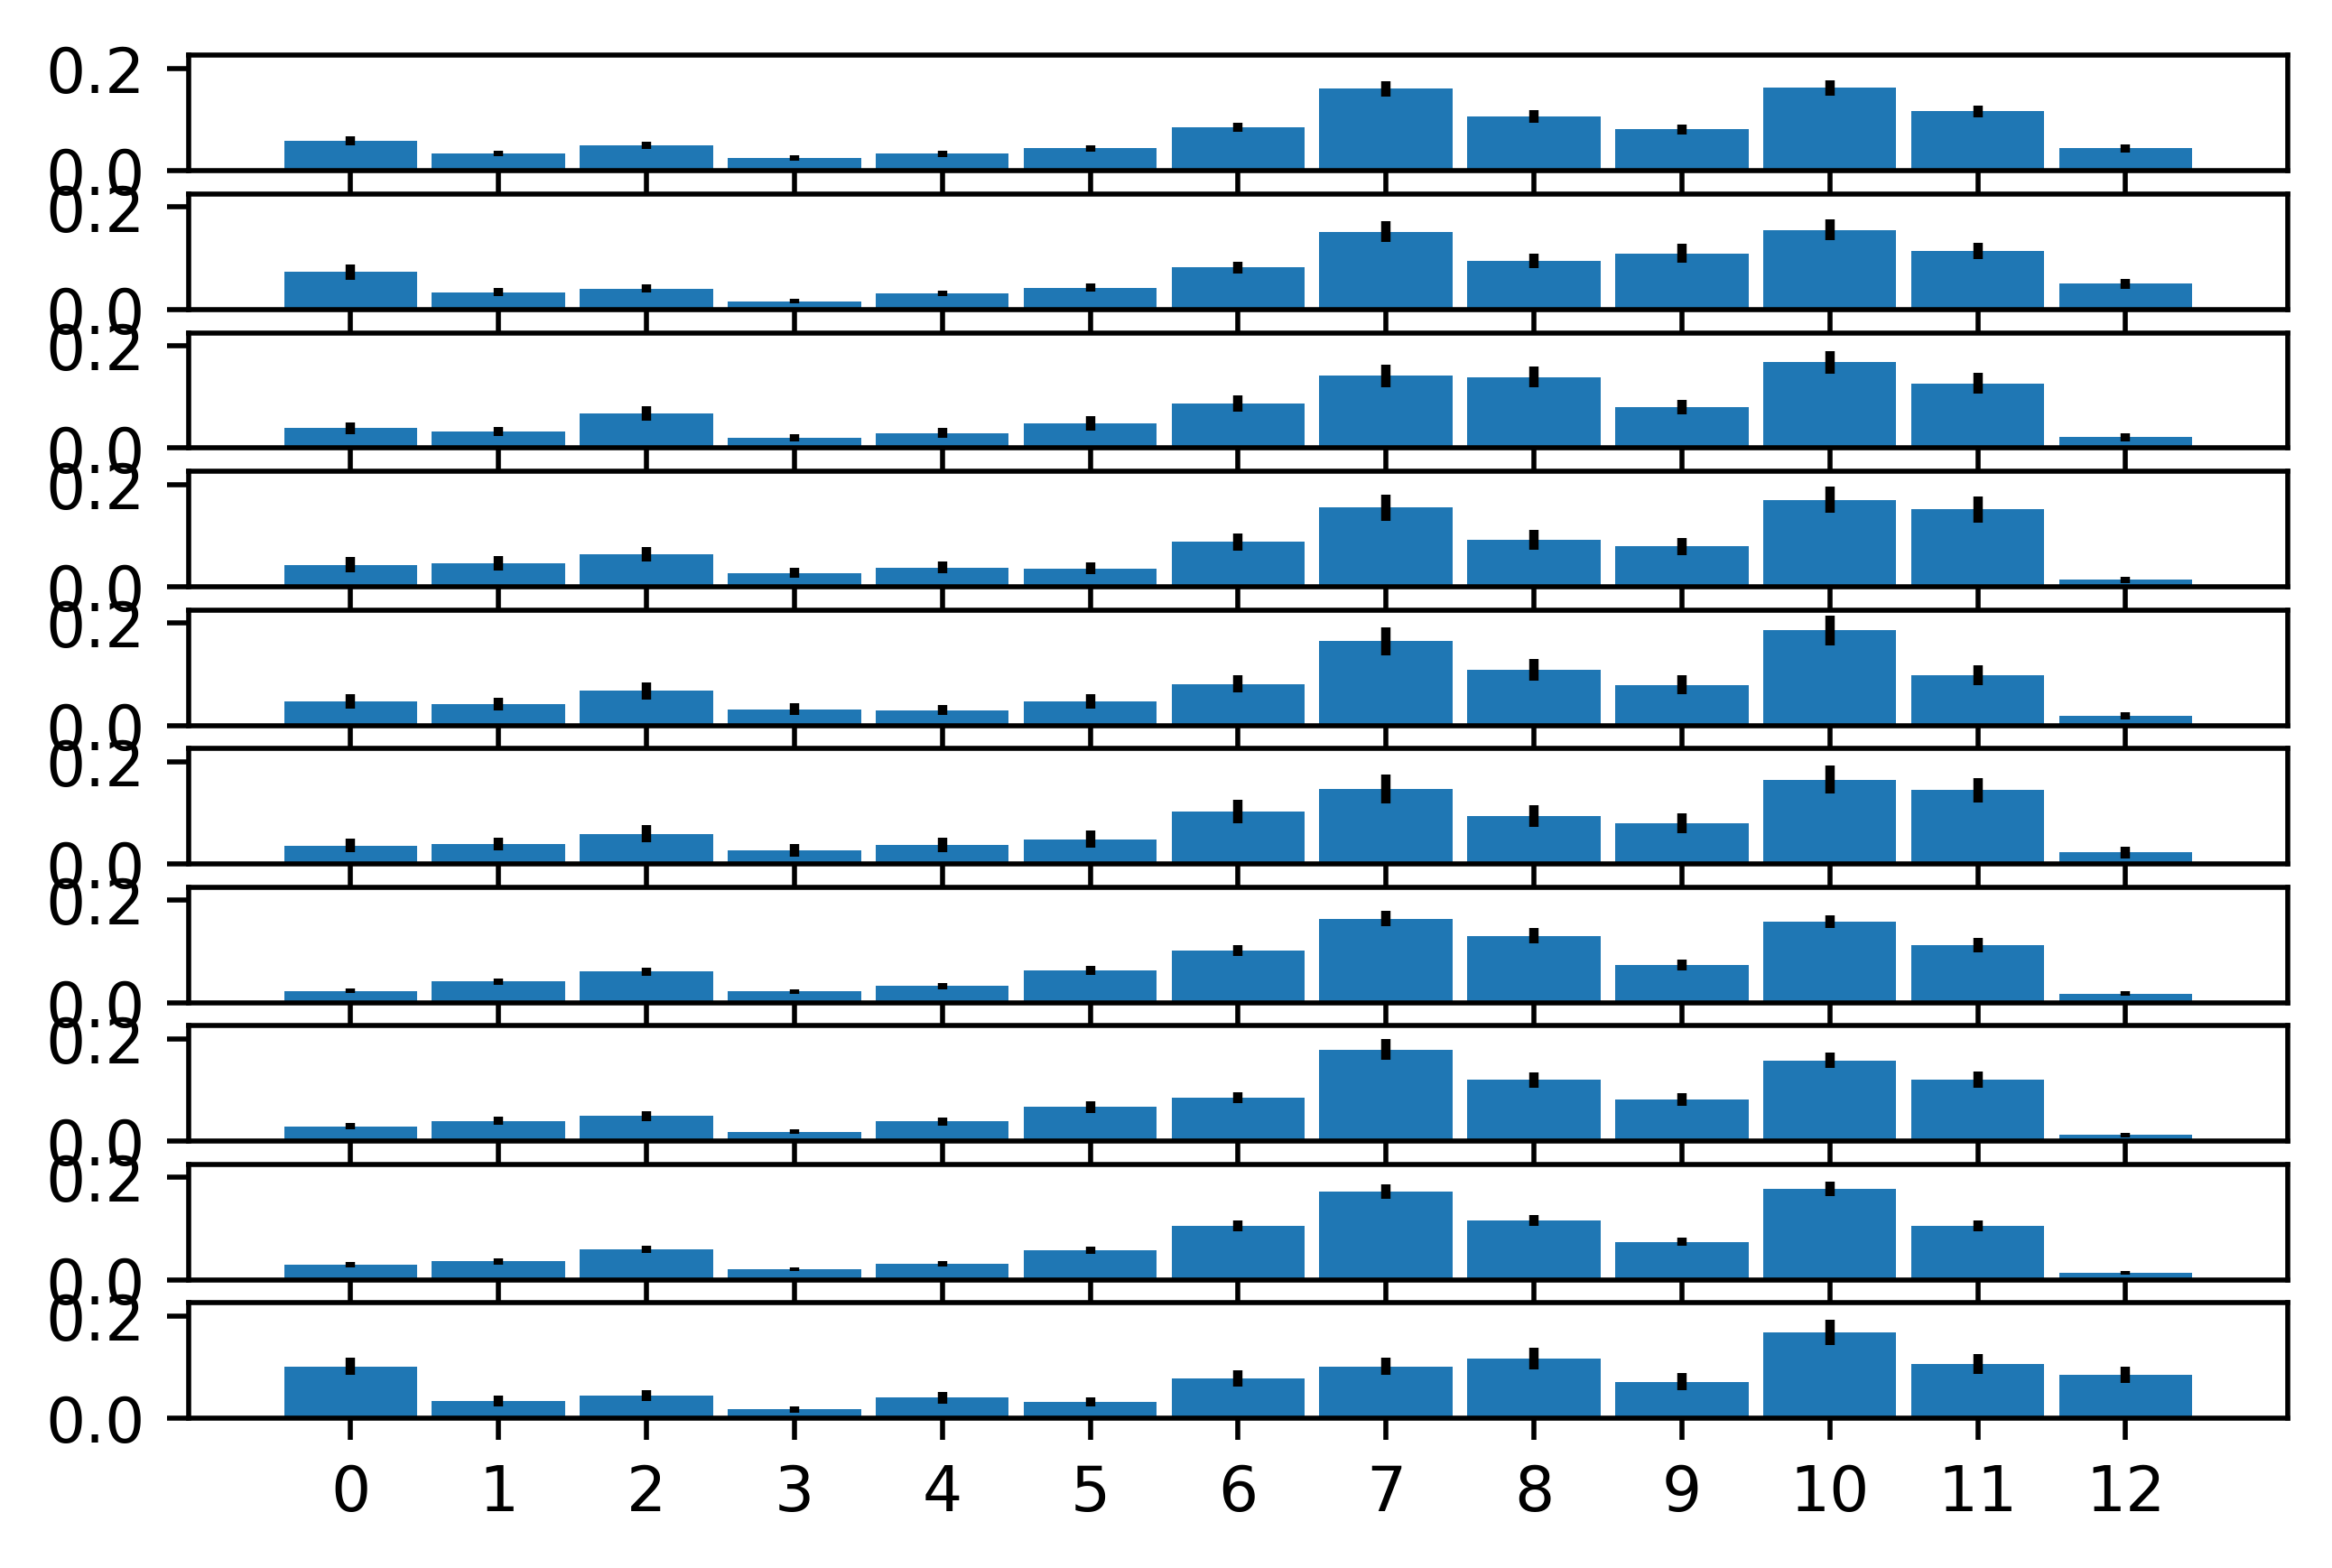

In [22]:

layer_reps_mat=get_result_mixing(['black','slumlordreach']).mean(axis=0).T
print(layer_reps_mat.shape)
layer_reps_mat=np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]).mean(axis=0)
print(layer_reps_mat.shape)
errors=get_result_mixing(['black','slumlordreach']).std(axis=0,ddof=1).T/np.sqrt(63)
errors=np.asarray([errors[:,:10],errors[:,10:]]).mean(axis=0)
fig,axarr=plt.subplots(nrows=10,sharex=True,sharey=True,dpi=500)
for i in range(10):
    axarr[i].bar(list(range(13)),layer_reps_mat[:,i],width=0.9,yerr=errors[:,i])
    axarr[i].set_xticks(list(range(13)))
    #axarr[i].set_title(rois[i])
#fig.tight_layout()

(12, 10)


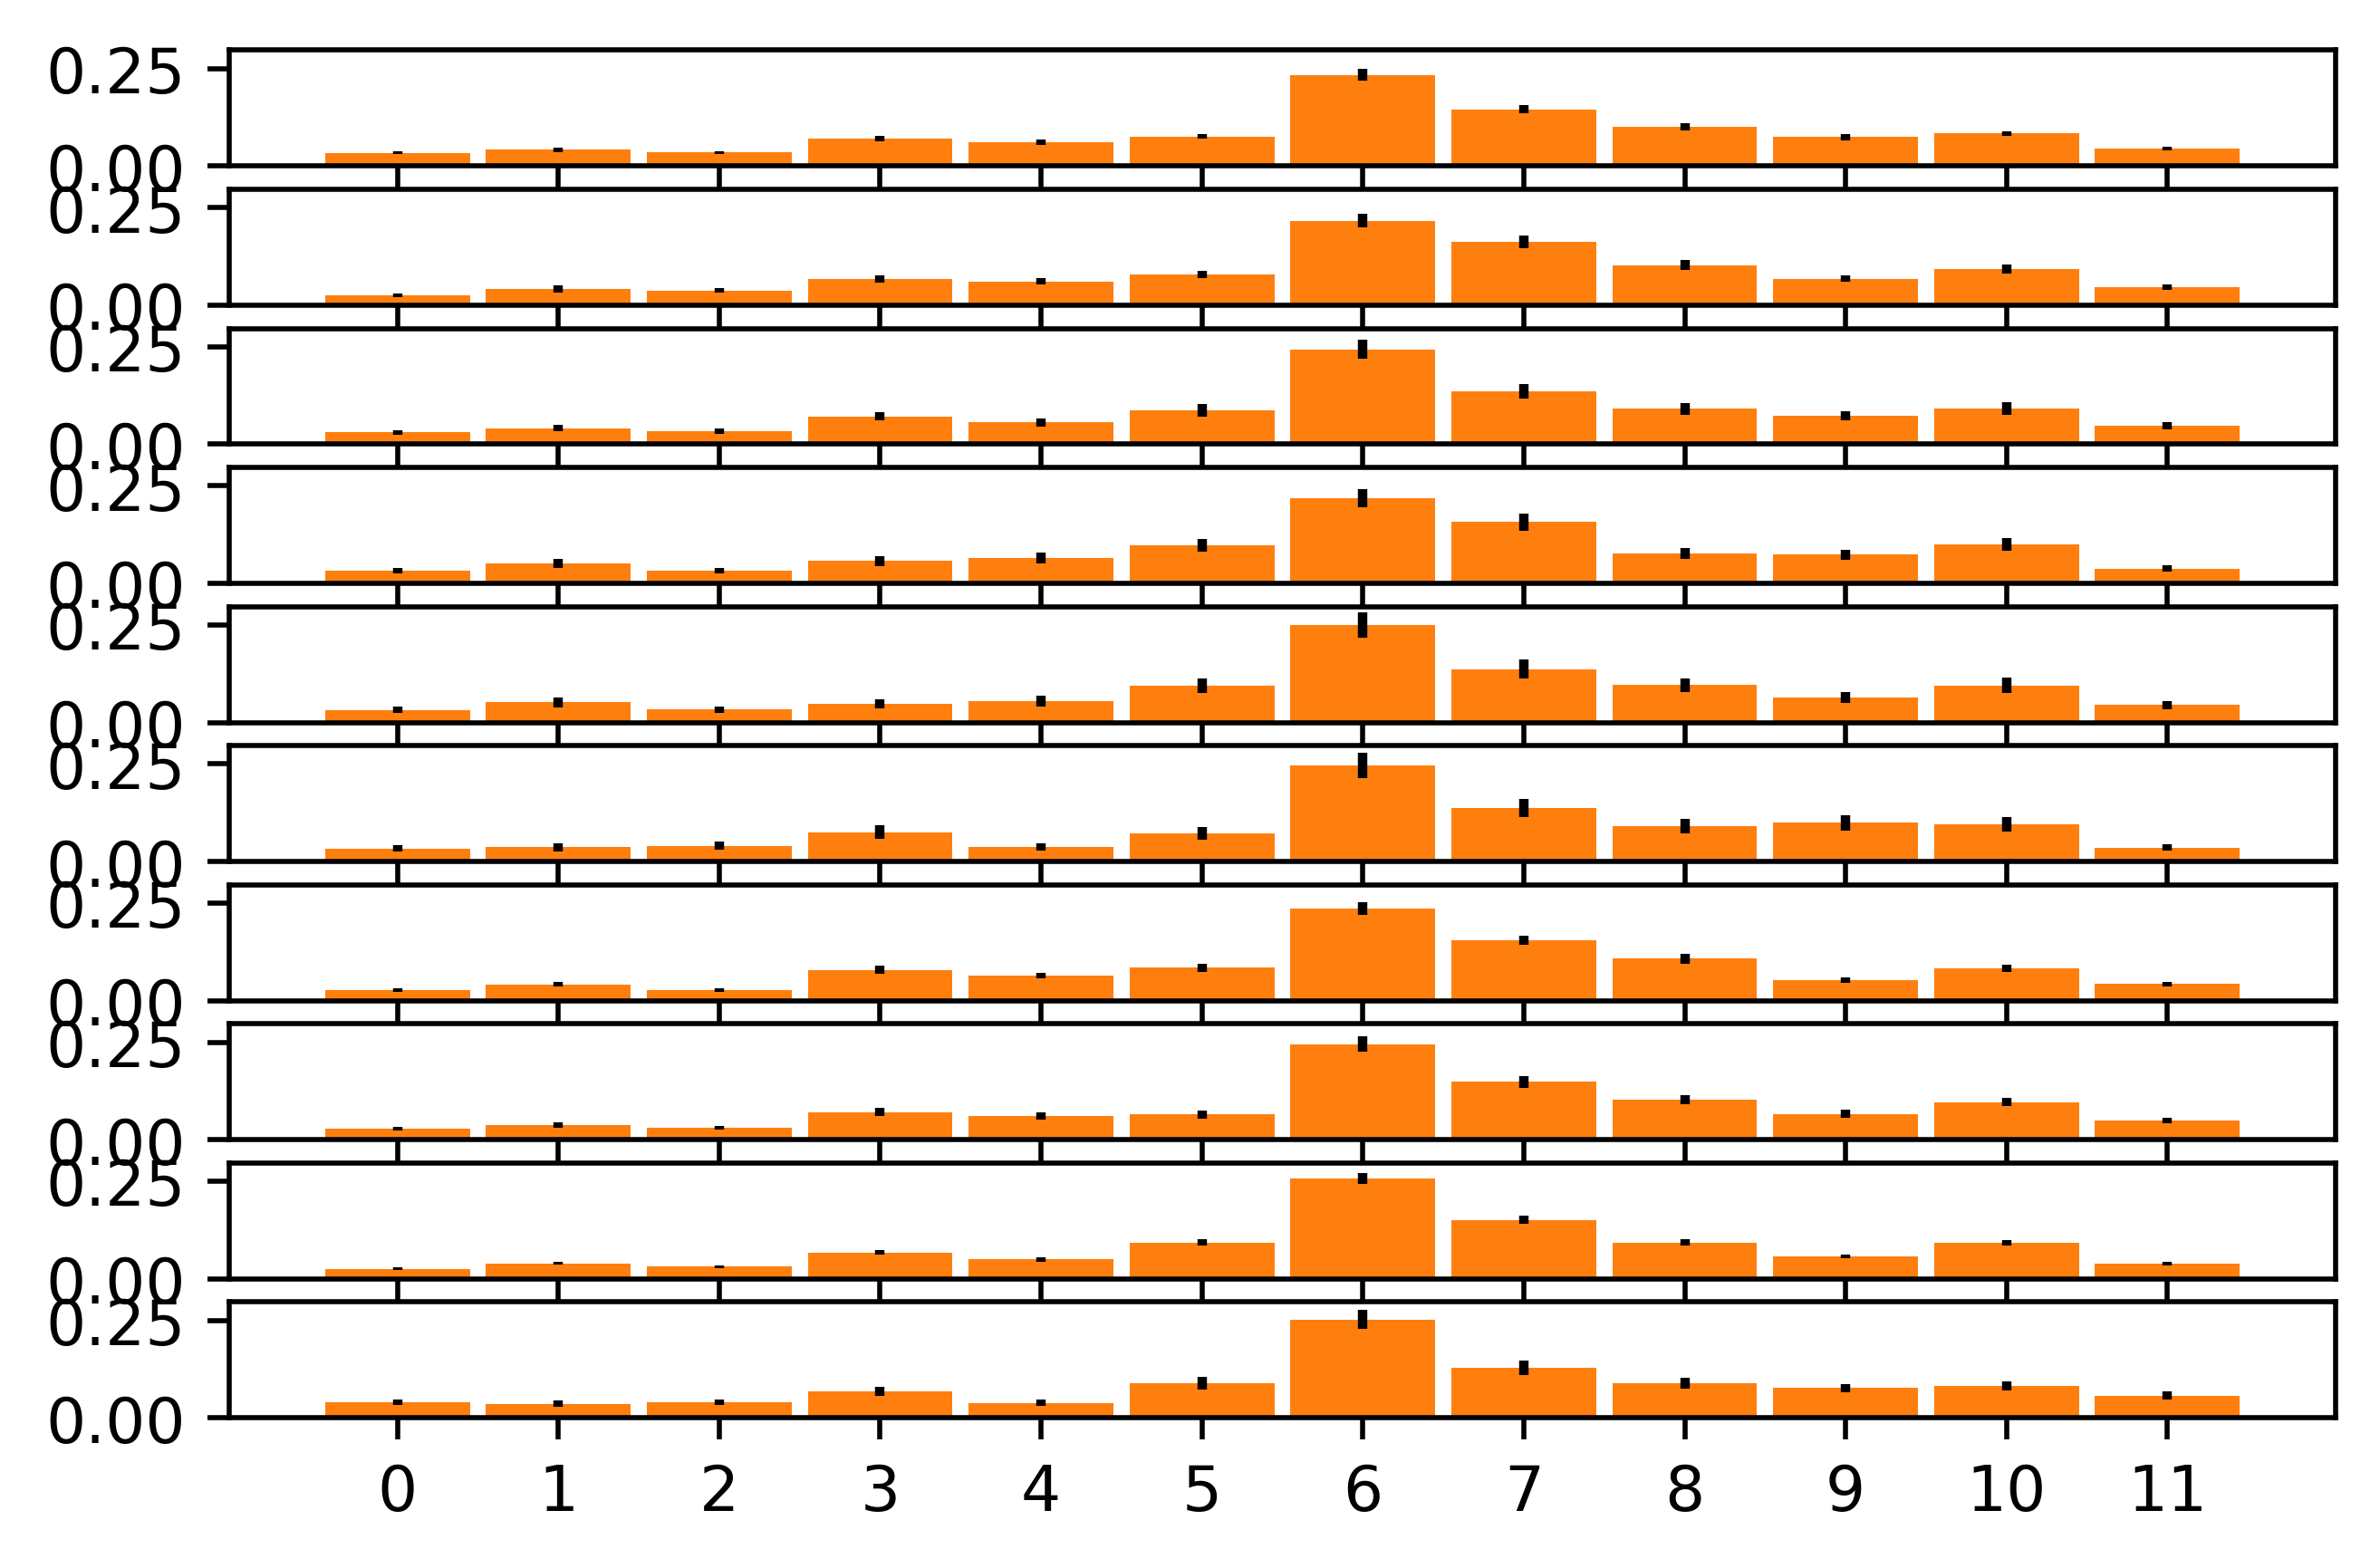

In [20]:

layer_reps_mat=get_result_mixing_z(['black','slumlordreach']).mean(axis=0).T
layer_reps_mat=np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]).mean(axis=0)
print(layer_reps_mat.shape)
errors=get_result_mixing_z(['black','slumlordreach']).std(axis=0,ddof=1).T/np.sqrt(63)
errors=np.asarray([errors[:,:10],errors[:,10:]]).mean(axis=0)
fig,axarr=plt.subplots(nrows=10,sharex=True,sharey=True,dpi=500)
for i in range(10):
    axarr[i].bar(list(range(12)),layer_reps_mat[:,i],width=0.9,yerr=errors[:,i],color='C1')
    axarr[i].set_xticks(list(range(12)))
    #axarr[i].set_title(rois[i])
#fig.tight_layout()

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Mean Mixing Weight')

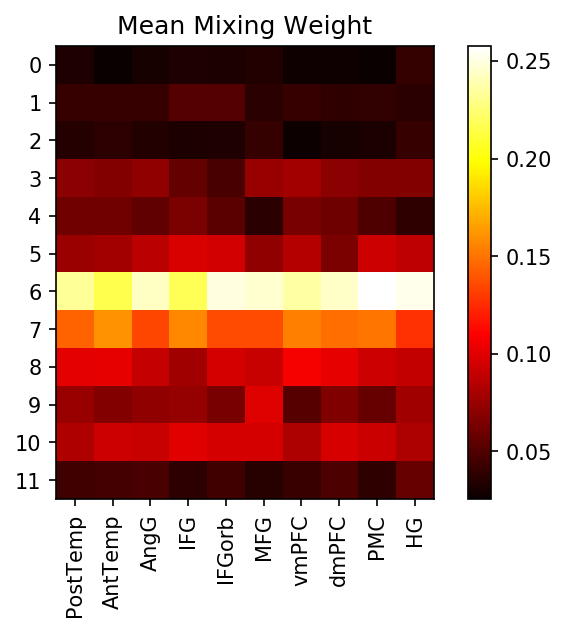

In [8]:
layer_reps_mat=get_result_mixing_z(['black','slumlordreach']).mean(axis=0).T
layer_reps_mat=np.mean(np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]),axis=0)
plt.figure(dpi=150)
plt.imshow(layer_reps_mat,cmap='hot')
plt.xticks(list(range(10)),rois,rotation=90)
plt.yticks(list(range(12)))
plt.colorbar()
plt.title("Mean Mixing Weight")